Sparsity constrains on neuronal activation are imposed with the following loss function 

\begin{equation}
    \mathcal{L}\left(\pmb{a}_1, \pmb{W}\right) = \frac{1}{2}|| \pmb{a}_0 - \pmb{W}^T \pmb{a}_1 ||_2^2 + \lambda S\left( \pmb{a}_1 \right)
\end{equation}

where $S(\pmb{x})$ denotes sparsity constraint typically assumed to be an L1 norm. For example, when $S(\pmb{x}) =  \sum_i C(x_i)$
and $C(x) = |x|$ we obtain the L1 norm, thus $S(\pmb{x}) = ||\pmb{x}||_1$. However, in practice the cost function $C(\cdot)$ can have any sutiable functional form (monotonically increasing with $x$  of x) more complex representation. 

The  gradient of the loss function with respect to single neuron activation $a_{1, i}$ is obtained as
$$ \begin{split} \frac{\partial  \mathcal{L}\left(\pmb{a}_1, \pmb{W}\right) }{\partial a_{1, i}} =&\: - \pmb{w}_i \left(\pmb{a}_0 - \pmb{W}^T \pmb{a}_1 \right) + \lambda C^\prime(a_{1,i})\\
=&\: - \pmb{w}_i \pmb{a}_0 + \pmb{w}_i \pmb{W}^T \pmb{a}_1 + \lambda \frac{ \partial S^\prime(\pmb{a}_1)}{\partial a_{1,i}} \\
=&\: - \pmb{w}_i \pmb{a}_0 + \left(\pmb{w}_i \pmb{W}^T - \pmb{e}_i \right) \pmb{a}_1 + a_{1, i} + \lambda C^\prime(a_{1,i})\end{split}$$

Setting the partial derivative to zero 
$$ \frac{\partial  \mathcal{L}\left(\pmb{a}_1, \pmb{W}\right) }{\partial a_{1, i}} \equiv 0 $$
we get the following relation

$$ u^*_i \equiv a^*_{1,i} + \lambda C^\prime(a^*_{1, i}) =  \pmb{w}_i \pmb{a}_0 - \pmb{V}_i \pmb{a}^*_{1}$$

To compute the fix point $\pmb{a}_1^*$ for which  

$$ \pmb{a}^*_{1} = \phi_{\alpha, \lambda, \gamma} \left( \pmb{W} \pmb{a}_0 - \pmb{V} \pmb{a}^*_{1} \right) $$

is satisfied, we can transform the above recurrent relation into the following system of ODEs 
$$ \frac{d \pmb{u}}{dt} = - \pmb{u} + \pmb{W} \pmb{a}_0 - \pmb{V} \pmb{a}_{1}, \text{ where } a_{1, i} = \phi_{\alpha, \lambda, \gamma}(u_i) $$
which corresponds to the mirror descent optimization algorithm.

Finally, for a general form of the activation function 

$$ \phi_{\alpha, \lambda, \gamma}(u) = \frac{u - \alpha \lambda}{1 + e^{-\gamma(u - \lambda)}}$$

we obtain the corresponding cost function $C_{\lambda, \gamma, \alpha}$, that is the sparsity constraint, from the following differential equation
$$ \lambda C^\prime(a_{1,i}) = u_i - a_{1,i} = u_i - \phi_{\alpha, \lambda, \gamma}(u_i)$$

Some special cases
    \begin{equation}
        \begin{split}
        \phi_{1, \lambda, \gamma\rightarrow\infty}(u) &= \begin{cases} 0, & \text{ if } u < \lambda \\ u - \lambda, & \text{ if } u \geq \lambda \end{cases} \implies C(a) = a\\
        \phi_{0, \lambda, \gamma\rightarrow\infty}(u) &= \begin{cases} 0, & \text{ if } u < \lambda \\ u , & \text{ if } u \geq \lambda \end{cases} \implies C(a) = 1, \text{ for } a \geq \lambda\\
        \end{split}
    \end{equation}

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import diffrax

from numpc.datasets import MNIST

from jax.scipy.optimize import minimize

from jax.nn import relu, swish, gelu, sigmoid
from jax import random, vmap

# load data
train_ds, test_ds = MNIST()

train_ds['image'] = train_ds['image'].reshape(train_ds['image'].shape[0], -1)
test_ds['image'] = test_ds['image'].reshape(test_ds['image'].shape[0], -1)

data_size, input_size = train_ds['image'].shape

/home/dima/.conda/envs/numpc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
import equinox as eqx

def activation(x, lam, alpha, gamma):
    return relu( (x - alpha * lam) * sigmoid(gamma * (x - lam)) )

class MirrorDescent(eqx.Module):    
    data_size: int
    hidden_size: int
    lam: float
    alpha: float
    gamma: float
    W: jnp.array
    V: jnp.array
    a: activation
    def __init__(self, data_size, hidden_size, W, lam=0.01, alpha=1., gamma=10., **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.W = W  # excitatory weights 
        self.V = W@W.T - jnp.eye(hidden_size)  # inhibitory weights
        self.lam = lam
        self.alpha = alpha
        self.gamma = gamma
        self.a = lambda x: activation(x, lam, alpha, gamma)
        
    def __call__(self, t, y, args):
        a = self.a(y)
        return - y + self.W @ args['I'] - self.V @ a

In [17]:
class NeuralActivity(eqx.Module):
    func: MirrorDescent
    initial: jnp.array
    solver: diffrax.AbstractSolver
    
    def __init__(self, data_size, hidden_size, func, solver, **kwargs):
        super().__init__(**kwargs)
        self.initial = jnp.zeros(hidden_size)
        self.func = func
        self.solver = solver

    def __call__(self, dt0, ts, inpt, evolving_out=False):
        term = diffrax.ODETerm(self.func)
        solver = self.solver()
        
        args = {
            'I': inpt 
        }
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            args=args,
            t0=ts[0],
            t1=ts[-1],
            dt0=dt0,
            y0=self.initial,
            saveat=saveat,
        )
        
        return self.func.a(solution.ys)

In [27]:
hidden_size = 100 
tmp = random.dirichlet(random.PRNGKey(0), jnp.ones(input_size)/jnp.sqrt(input_size), (hidden_size,))
W = jnp.sqrt(tmp)

loss = jnp.square(train_ds['image']).sum()/2

func = MirrorDescent(data_size, hidden_size, W)
solver = diffrax.Heun
nn_act = NeuralActivity(data_size, hidden_size, func, solver)
ts = [0, 10]
dt0 = 0.25

res_pp = vmap(lambda x: nn_act(dt0, ts, x))(train_ds['image'])
%timeit vmap(lambda x: nn_act(dt0, ts, x))(train_ds['image']).block_until_ready()
pp_loss = (jnp.square(train_ds['image'] - res_pp.squeeze() @ W).sum()/2 + func.lam * res_pp.sum())/data_size
print(loss/data_size, pp_loss)

54.2 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
43.90501 33.970695


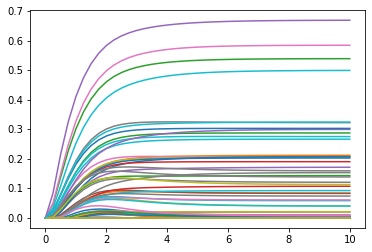

In [28]:
ts = jnp.arange(ts[0], ts[-1] + dt0, dt0)
plt.plot(ts, nn_act(dt0, ts, train_ds['image'][0], evolving_out=True));

In [52]:
def loss(lam=1., alpha=1):
    func = MirrorDescent(data_size, hidden_size, W, lam=lam, alpha=alpha)
    solver = diffrax.Heun
    nn_act = NeuralActivity(data_size, hidden_size, func, solver)
    ts = [0, 10]
    dt0 = 0.25

    res = vmap(lambda x: nn_act(dt0, ts, x))(train_ds['image'])
    if alpha == 1:
        return (jnp.square(train_ds['image'] - res.squeeze() @ W).sum()/2 + func.lam * res.sum())/data_size
    else:
        return (jnp.square(train_ds['image'] - res.squeeze() @ W).sum()/2 + func.lam * (res >= func.lam).sum())/data_size

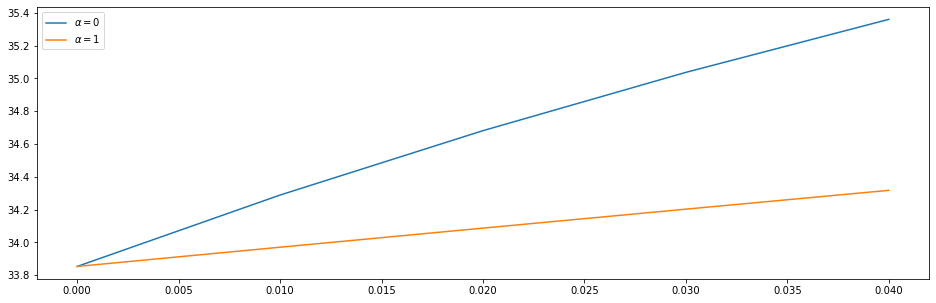

In [53]:
lams = jnp.arange(0, 0.05, 0.01)
fig, axes = plt.subplots(1, 1, figsize=(16, 5), sharex=True, sharey=True)
for i, alpha in enumerate([0, 1]):
    md_losses = vmap(lambda x: loss(lam=x, alpha=alpha))(lams)
    axes.plot(lams, md_losses, label=r'$\alpha={}$'.format(alpha))
plt.legend();

In [133]:
from jax.lax import fori_loop

def training(a0s, n_iters = 1000, lam=0.):
    hidden_size = 100 
    tmp = random.normal(random.PRNGKey(0), (hidden_size,input_size))/jnp.sqrt(input_size)
    W = tmp/jnp.sqrt(jnp.sum(jnp.square(tmp), -1, keepdims=True))
    
    ts = [0, 10]
    dt0 = 0.25

    def loop_fn(i, carry):
        W, _ = carry
        func = MirrorDescent(data_size, hidden_size, W, lam=lam, alpha=0., gamma=1.)
        solver = diffrax.Heun
        nn_act = NeuralActivity(data_size, hidden_size, func, solver)
        
        a1s = vmap(lambda x: nn_act(dt0, ts, x))(a0s).squeeze()
        
        _W = W + jnp.einsum('...i,...j->ij', a1s, (a0s - a1s @ W))/data_size
        _W /= jnp.sqrt(jnp.sum(jnp.square(_W), -1, keepdims=True))
        return (_W, a1s)
    
    init_val = (W, jnp.zeros((data_size, hidden_size)))
    W, a1s = fori_loop(0, n_iters, loop_fn, init_val)
    return W, a1s

lam = 0.0
W, a1s = training(train_ds['image'],n_iters=100, lam=lam)
md_loss = (jnp.square(train_ds['image'] - a1s @ W).sum()/2)/data_size
print(jnp.square(train_ds['image']).sum()/(2*data_size) , md_loss)

# NOTE: the lowest L2 loss is achieved for us(u) activation function

43.90501 7.967786


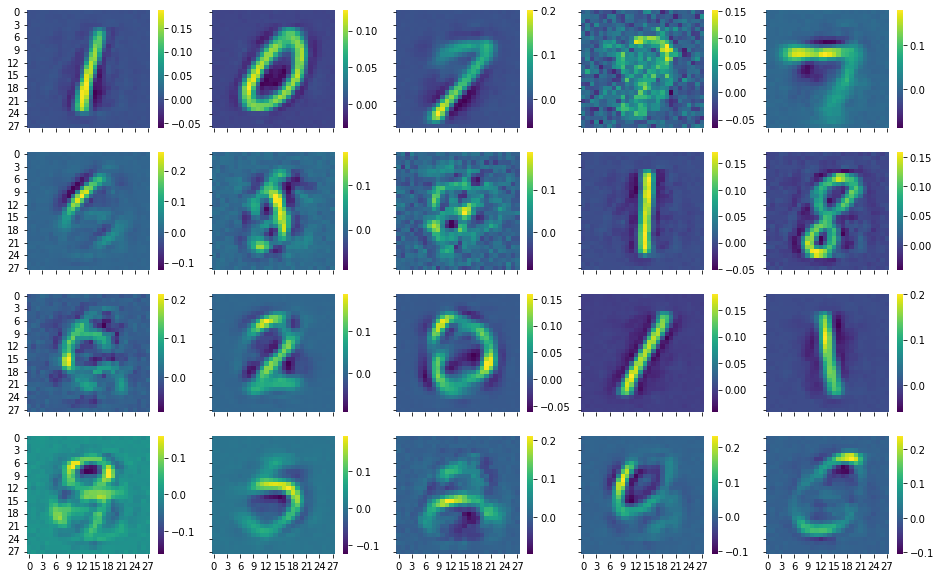

In [135]:
fig, axes = plt.subplots(4, 5, figsize=(16, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    sns.heatmap(W[i].reshape(28, 28), cmap='viridis', ax=ax)